In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
q = 0.1
fname = "DATA/dataRBM_q"+str(q)+".csv"
# Visible data
v = np.loadtxt(fname,delimiter=",",dtype=int)
N = len(v)
# Length of sample
L = len(v[0])
print(f"Each of N={N} data samples has L={L} digits.")

q = 0
fname = "DATA/dataRBM_q"+str(q)+".csv"
# Visible data not corrupted
v_true = np.loadtxt(fname,delimiter=",",dtype=int)

print("...")

# Choice of using -1/+1 and not 0,1
SPINS = True
if SPINS:
    vmin = -1
# The energy gap now is 2 not 1
    GAP  = 2  
    v = 2*v -1
    v_true = 2*v_true -1 
else:
    vmin = 0
    GAP = 1

# Store initial values
v0 = np.zeros_like(v)
v0[:] = v[:]


for n in range(10):
    print(v[n])

print("...")

Each of N=10000 data samples has L=8 digits.
...
[-1  1 -1 -1  1 -1  1  1]
[ 1  1 -1  1  1 -1 -1  1]
[-1  1  1  1 -1 -1  1  1]
[-1 -1  1  1  1  1 -1 -1]
[-1 -1  1  1 -1 -1  1 -1]
[ 1  1 -1 -1  1 -1 -1 -1]
[-1  1  1 -1  1  1 -1 -1]
[ 1  1 -1 -1 -1 -1  1  1]
[ 1 -1 -1  1  1  1 -1  1]
[ 1 -1 -1 -1 -1 -1  1 -1]
...


In [ ]:
# Number of hidden units
M = 3

# This is good, is written in the review the denom is prop to the lenght of M
sigma = np.sqrt(4. /float(L + M))
np.random.seed(12345)

# Numbers in [-sigma;sigma]
w = sigma * (2*np.random.rand(L,M) - 1)
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)
print(f"w = {w}\na = {a}\nb = {b}")
w0,a0,b0 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)
w0[:],a0[:],b0[:] = w[:],a[:],b[:]

w = [[ 0.5181365  -0.22145941 -0.38120826]
 [-0.35631371  0.08167946  0.11523125]
 [ 0.56022559  0.18473853  0.3001927 ]
 [ 0.18521223  0.2987553   0.55635686]
 [-0.59290602 -0.47464594 -0.24277246]
 [ 0.18863898  0.373648    0.44886104]
 [ 0.56038609  0.26977468  0.17183171]
 [ 0.26225893 -0.03907707 -0.21035279]]
a = [-0.07279134  0.27701546  0.59580401  0.21331772  0.35074515 -0.39689234
 -0.57064124  0.36226014]
b = [0. 0. 0.]


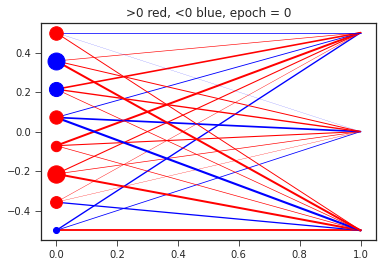

In [ ]:
def create_coord(np,x0):
    x = [x0] * np
    y = list(range(np))
    #y = y/(np - 1.) - .5
    for i in range(np):
            y[i] = y[i]/(np - 1.) - .5
    return(x,y)

(x1,y1) = create_coord(L,0)
(x2,y2) = create_coord(M,1)
             
def mycolor(val):
    if val>0:
        return "red"
    elif val<0:
        return "blue"
    return"black"

def plotgraph(w,a,b,epoch=0):
    A = 2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]), (y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*np.abs(w[i][j]))
    A = 300./(a.max() + b.max())
    # plot units
    for i in range(L):
        plt.scatter(x1[i],y1[i],s=A*np.abs(a[i]),zorder=2,c=mycolor(a[i]))
    A = 300./(a.max() + b.max())
    # plot units
    for j in range(M):
        plt.scatter(x2[j],y2[j],s=A*np.abs(b[j]),zorder=2,c=mycolor(b[j]))
    plt.title(f">0 red, <0 blue, epoch = {epoch}")
    plt.show()

plotgraph(w,a,b)

In [ ]:
def activate(v_in, wei, bias, DE, β = 1, info=False):
    act = np.dot(v_in,wei) + bias
    prob = 1. / (1. + np.exp(-DE * β * act))
    n = len(act)
    v_out = np.full(n,vmin)
    # Stochastic part
    v_out[np.random.random_sample(n) < prob] = 1
    if info:
        print("input = ",v_in)
        print("act   = ",act)
        print("prob  = ",prob)
        print("out   = ",v_out)
    return (v_out)

activate(v[0],w,b,GAP,True)

array([0, 1, 0])

In [ ]:
def RBM(w, v, a, b, M, nepoch = 50, mini = 500, l_rate = 1.0, plot = False, ev = False):
    m = 0
    ws  = np.zeros_like(w)
    asa = np.zeros_like(a)
    bs  = np.zeros_like(b)
    ws[:]  = w[:]
    asa[:] = a[:]
    bs[:]  = b[:]
    mean_mean_dw = []
    for epoch in range(1,nepoch+1):
        mean_dw = []
        for n in range(N):
            if m==0:
                # initialize the minibatch
                v_data, v_model   = np.zeros(L), np.zeros(L)
                h_data, h_model   = np.zeros(M), np.zeros(M)
                vh_data, vh_model = np.zeros((L,M)), np.zeros((L,M))

            # Positive CD phase
            h  = activate(v[n],ws,bs,GAP)
            # Negative CD phase
            vf = activate(h,ws.T,asa,GAP)
            # Positive CD phase nr 2
            hf = activate(vf,ws,bs,GAP)

            v_data  += v[n]
            v_model += vf
            h_data  += h                
            h_model += hf

            vh_data  += np.outer(v[n].T, h)
            vh_model += np.outer(vf.T, hf)

            m += 1

            if m==mini:
                C  = l_rate / mini
                dw = C*(vh_data - vh_model)
                da = C*(v_data - v_model)
                db = C*(h_data - h_model)
                # if epoch <=2 and n>=mini:
                #     print("--- epoch = ",epoch, "   n = ",n, "    m = ",m)
                #     print("dw = ",dw)
                #     print("da = ",da)
                #     print("db = ",db)

                ws += dw
                asa += da
                bs += db
                m = 0

                if ev:
                    mean_dw.append(np.sum(dw**2) / (L*M))
        if ev:            
            mean_mean_dw.append(np.mean(mean_dw))
            

        # randomize order
        np.random.shuffle(v)
        l_rate = l_rate /(0.05 * l_rate + 1) 
        if plot:
            if epoch %5 ==0:
                plotgraph(ws,asa,bs,epoch)
                print("l_rate = ",l_rate)
    return ws,asa,bs,mean_mean_dw

In [ ]:
def comparison(x, x_true, pix):
    """
    Input:
        x -> Vector to compare
        x_true -> True vector
        pix -> pixel of confident
    Output:
        c/N -> rateo of pattern retrived by the algorithm
    """
    # x = np.asarray(x)
    # x_true = np.asarray(x_true)
    N = x.shape[0]
    K = x.shape[1]
    #print(N)
    #print(K)
    if (x.shape != x_true.shape):
        exit("Different shapes of the vectors to compare")
    c = 0
    for i in range(N):
        k = 0
        for j in range(K):
            if (x[i,j]==x_true[i,j]):
                k+=1
        if (k>= K-pix):
            c += 1
    
    return c/N

In [ ]:
l_rate = 1.0 
# minibatches
mini, m = 500, 0
# epochs
nepoch = 50
score_both = []
score_1 = []
score_2 = []

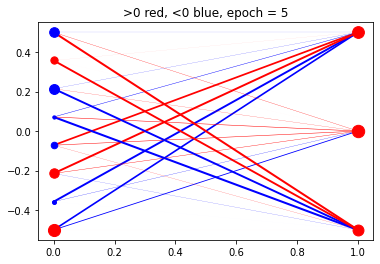

l_rate =  0.7999999999999998


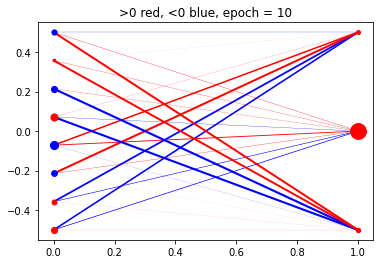

l_rate =  0.6666666666666663


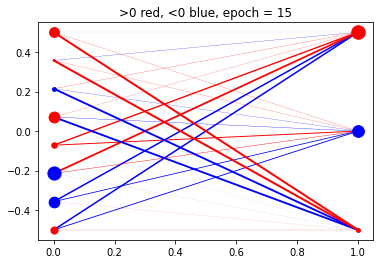

l_rate =  0.5714285714285713


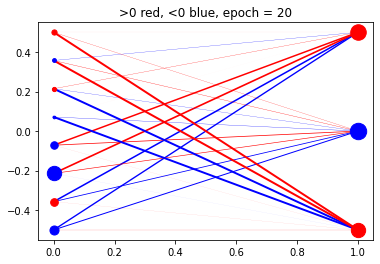

l_rate =  0.5


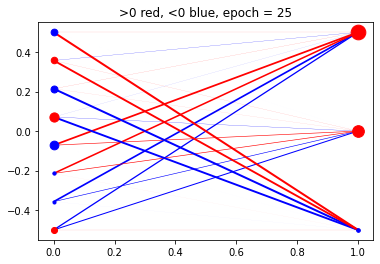

l_rate =  0.4444444444444445


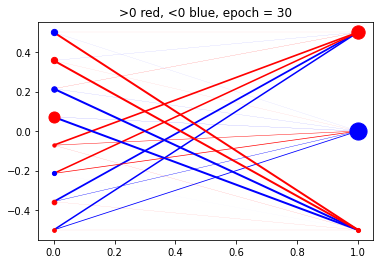

l_rate =  0.4000000000000001


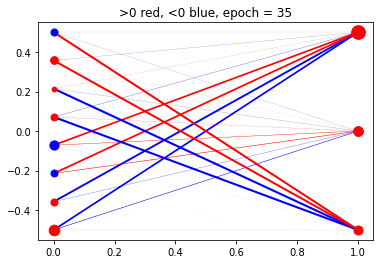

l_rate =  0.3636363636363637


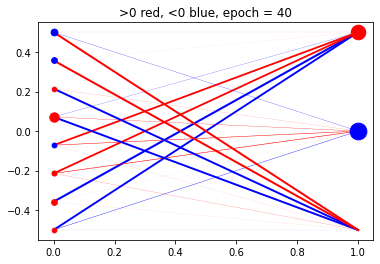

l_rate =  0.3333333333333335


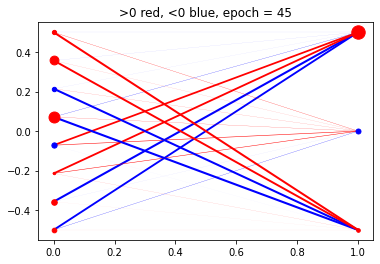

l_rate =  0.3076923076923079


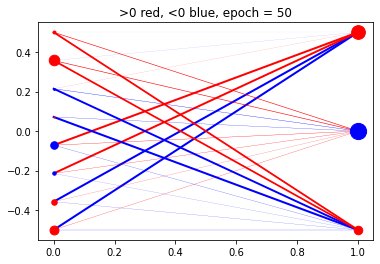

l_rate =  0.28571428571428586


In [ ]:
w1, a1, b1 = RBM(w, v, a, b, M, plot=True)

In [ ]:
pixi = 0
betas = np.linspace(1,16,50)

In [ ]:
score_both = []
for beta in betas:
    v1 = np.full((N,L),vmin)
    for n in range(N):
        h = activate(v0[n], w1, b1, GAP, β = beta)
        v1[n] = activate(h, w1.T, a1, GAP, β = beta)
    score_both.append(comparison(v1, v_true, pixi))

In [ ]:
score_2 = []
for beta in betas:
    v1 = np.full((N,L),vmin)
    for n in range(N):
        h = activate(v0[n], w1, b1, GAP)
        v1[n] = activate(h, w1.T, a1, GAP, β = beta)
    score_2.append(comparison(v1, v_true, pixi))

In [ ]:
score_1 = []
for beta in betas:
    v1 = np.full((N,L),vmin)
    for n in range(N):
        h = activate(v0[n], w1, b1, GAP, β = beta)
        v1[n] = activate(h, w1.T, a1, GAP)
    score_1.append(comparison(v1, v_true, pixi))

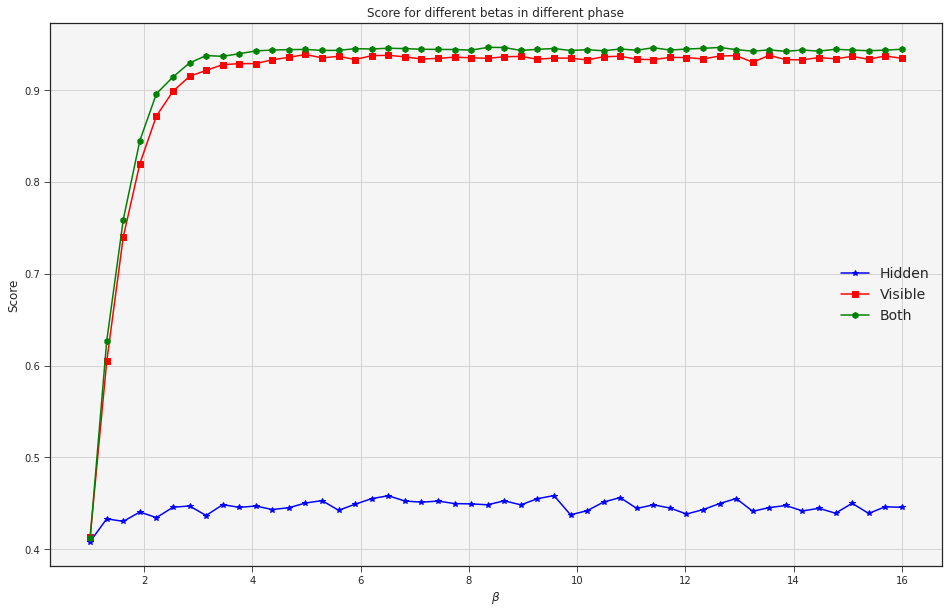

In [ ]:
plt.style.use('seaborn-ticks')
plt.figure(figsize=(16,10))
ax = plt.axes()
ax.set_facecolor("whitesmoke")
plt.title("Score for different betas in different phase")


plt.xlabel("$\\beta$", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.plot(betas,score_1,'b',label="Hidden",marker='*')
plt.plot(betas,score_2,'r',label="Visible",marker='s')
plt.plot(betas,score_both,'g',label="Both",marker='h')
plt.grid()
plt.legend(fontsize=14,loc="best")

plt.show()

In [ ]:
l_rate = 1.0 
# minibatches
mini, m = 500, 0
# epochs
nepoch = 50
score_both = []
score_1 = []
score_2 = []

In [ ]:
w2, a2, b2, mean_dw = RBM(w, v, a, b, M, plot=False, ev = True)

In [ ]:
w2_false, a2_false, b2_false, mean_dw_false = RBM(w, v, a, b, M, plot=False, ev = True)

In [ ]:
mean_dw

[0.008578400000000002,
 0.0021196976568405137,
 0.0017320110192837457,
 0.001763906742281033,
 0.0015861805555555553,
 0.0015632426666666662,
 0.0013423274161735693,
 0.0012234659350708727,
 0.0011392006802721081,
 0.0012328180737217588,
 0.0009600444444444434,
 0.0008928338536246959,
 0.0008309505208333328,
 0.0008038200183654722,
 0.0007350634371395613,
 0.0007162666666666662,
 0.0005763683127572015,
 0.0006474019965911856,
 0.0005520036934441367,
 0.0005506640368178829,
 0.0005068750000000001,
 0.00046738845925044627,
 0.0005249508692365837,
 0.0005136974941409771,
 0.00044157713498622594,
 0.0004587654320987655,
 0.0004547700063011975,
 0.0003933182435491172,
 0.0003494791666666668,
 0.0003603498542274053,
 0.0003095360000000001,
 0.0003222555427399718,
 0.00032110453648915194,
 0.0003302954788180849,
 0.00030680841335162343,
 0.00025389311294765854,
 0.00026620748299319743,
 0.0002663342566943677,
 0.0002469916765755056,
 0.000264311021737049,
 0.0002562962962962965,
 0.0002184789

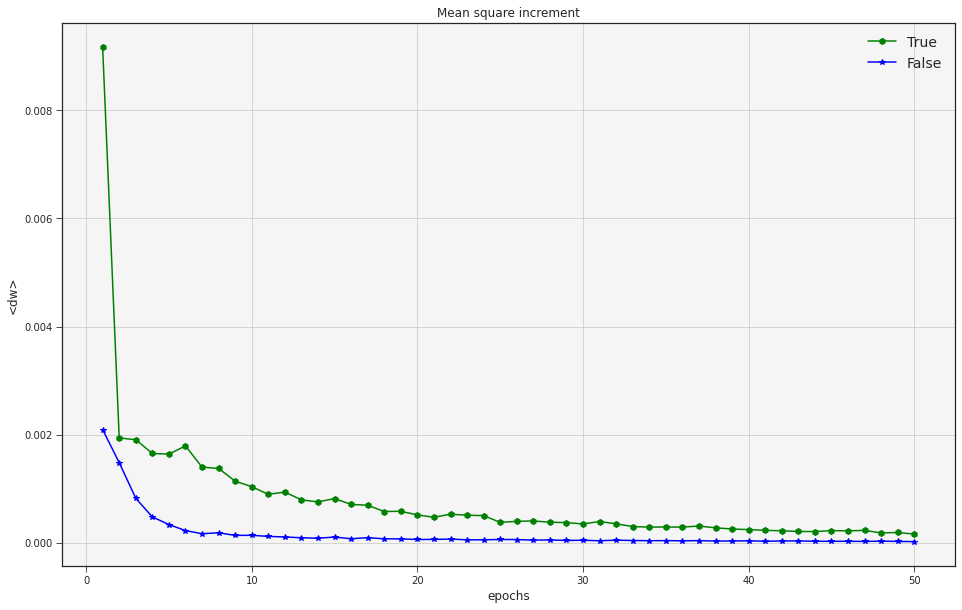

In [ ]:
epochs = np.arange(1,51)
plt.style.use('seaborn-ticks')
plt.figure(figsize=(16,10))
ax = plt.axes()
ax.set_facecolor("whitesmoke")
plt.title("Mean square increment")


plt.xlabel("epochs", fontsize=12)
plt.ylabel("<dw>", fontsize=12)
plt.plot(epochs, mean_dw,'g',label="True",marker='h')
plt.plot(epochs,mean_dw_false,'b',label="False",marker='*')
plt.grid()
plt.legend(fontsize=14,loc="best")

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dc341315-a668-4e89-92e9-cab634ea884a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>